In [ ]:
#!mamba install -y streamlit
#!mamba install -y matplotlib yfinance scipy

In [53]:
import streamlit as st
import utils
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np
from datetime import datetime, timedelta
import pandas as pd

st.write("""
# Stockmarket Oracle
At what price should i buy or sell my stock?
""")

choices = ["^GDAXI", "^DJI", "GC=F", "BTC-EUR", "META" ,"AMZN","DTE.DE"]

selected_stock = st.selectbox("stock", choices)

st.set_option('deprecation.showPyplotGlobalUse', False)

def get_prices(symbol, days, start=None, end=None):
    st.write("loading...")
    stock =  yf.Ticker(symbol)
    if not start and not end:        
        # Determine minimal data
        df = stock.history(period="max")
        start_date = df.index.min()
        current_date = df.index.max()
    else:
        if not end:
            current_date = (datetime.today()  + timedelta(1))
        if not start:
            start_date = stock.history(period="max").index.min()
        df = stock.history(start=start_date, end=current_date)

    st.write("data loaded...")
    # Determine minimal date  
    price = df['Close']
    price = price.values
    
    mu_est, sigma_est = utils.compute_parameter(price ,price.size) # The last var is how many days we are looking at
    
    dates= df.index
    interp=30
    buy=[0] * interp
    sell=[0] * interp
    prop_buy=[0] * interp
    prop_sell=[0] * interp
    time=[0] * interp
    i=0
    gap=50
    obs_range=list(range(0,price.size))
    while i<interp:
        buy[i], sell[i], prop_buy[i], prop_sell[i] = utils.optimal_limits_exact(mu_est, sigma_est, price[-1], i*gap+1)   #100 days in advance
        time[i] = current_date + timedelta(days=i*gap)
        obs_range = obs_range+[price.size+i*gap]
        i=i+1
    trend = [price[0]*np.exp(np.array(obs_range)*(mu_est -0.5*sigma_est**2))]
    
    #return (df.index, trend[0], df['Close'], buy, sell, prop_buy, prop_sell, time)
    return pd.DataFrame({"Date": list(df.index) + time, "trend": trend[0], "closing_price": list(df['Close']) + [np.nan] * interp, "best_buy_price": [np.nan] * price.size + buy, "best_sell_price": [np.nan] * price.size + sell, "prop_buy_price": [np.nan] * price.size + prop_buy, "prop_sell_price": [np.nan] * price.size + prop_sell})

st.write(f"""
The best prices for {selected_stock}
""")

result = get_prices(selected_stock, 5)

2022-11-27 15:57:43.370 upper bound for the integral was set to 1753510.7404170802
2022-11-27 15:57:43.861 upper bound for the integral was set to 1753510.7404170802
2022-11-27 15:57:44.353 upper bound for the integral was set to 1753510.7404170802
2022-11-27 15:57:44.831 upper bound for the integral was set to 1753510.7404170802
2022-11-27 15:57:45.295 upper bound for the integral was set to 1753510.7404170802
2022-11-27 15:57:45.707 upper bound for the integral was set to 1753510.7404170802
2022-11-27 15:57:46.180 upper bound for the integral was set to 1753510.7404170802
2022-11-27 15:57:46.632 upper bound for the integral was set to 1753510.7404170802
2022-11-27 15:57:47.099 upper bound for the integral was set to 1753510.7404170802
2022-11-27 15:57:47.539 upper bound for the integral was set to 1753510.7404170802
2022-11-27 15:57:47.948 upper bound for the integral was set to 1753510.7404170802
2022-11-27 15:57:48.371 upper bound for the integral was set to 1753510.7404170802
2022

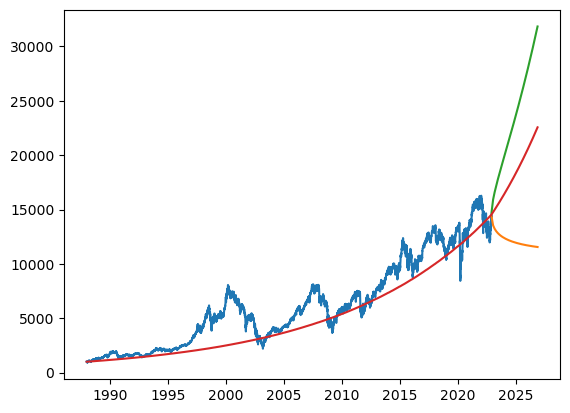

In [54]:
result
plt.plot(result["Date"], result["closing_price"])
plt.plot(result["Date"], result["best_buy_price"])
plt.plot(result["Date"], result["best_sell_price"])
plt.plot(result["Date"], result["trend"])
#st.pyplot(fig=fig)

In [57]:
import altair as alt
melted_result= result.melt(id_vars=['Date'], value_vars=['closing_price', 'best_sell_price', 'best_buy_price', 'trend'], value_name='Price')
alt.data_transformers.disable_max_rows()
alt.Chart(melted_result).mark_line().encode(
    x='Date',
    y='Price',
    color='variable'
)

/opt/conda/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)